In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from pathlib import Path
import cv2
import numpy as np
import random
from tqdm import tqdm

# ===============================
# 설정
# ===============================
INPUT_DIR = Path("/home/dw/ws_job_msislab/Golf_Project/data/for_aug_test")
OUTPUT_DIR = INPUT_DIR / "output_global"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

IMG_EXTS = [".jpg", ".jpeg", ".png", ".bmp", ".webp"]

# ===============================
# 🌞 전역 밝기 / 색온도 변조 함수
# ===============================
def add_global_light(image, mode="bright"):
    """이미지 전체를 밝게 또는 따뜻한 톤으로 변경"""
    img = image.astype(np.float32) / 255.0
    if mode == "bright":
        alpha = random.uniform(1.1, 1.5)  # 밝기 배율
        beta = random.uniform(0.05, 0.15)  # 추가 명도
        img = img * alpha + beta
        img = np.clip(img, 0, 1)
        # 따뜻한 톤 추가 (햇빛 느낌)
        warm_shift = np.array([random.uniform(-0.02, 0.05), 0, random.uniform(0.02, 0.08)])
        img = np.clip(img + warm_shift, 0, 1)
    return (img * 255).astype(np.uint8)


def add_global_shadow(image):
    """이미지 전체를 살짝 어둡게 (그늘 느낌)"""
    img = image.astype(np.float32) / 255.0
    alpha = random.uniform(0.6, 0.85)  # 전체 어두움 정도
    # 살짝 푸른 톤으로 이동 (그늘 느낌)
    cool_shift = np.array([random.uniform(0.02, 0.05), random.uniform(0.00, 0.03), random.uniform(-0.05, -0.02)])
    img = img * alpha + cool_shift
    img = np.clip(img, 0, 1)
    return (img * 255).astype(np.uint8)


def add_random_global_effect(image):
    """랜덤하게 전체 밝음/그늘/중간톤 적용"""
    r = random.random()
    if r < 0.4:
        # 전체 밝게 (햇빛 강한 상태)
        return add_global_light(image, mode="bright")
    elif r < 0.8:
        # 전체 어둡게 (그늘)
        return add_global_shadow(image)
    else:
        # 살짝 대비 증가 (약간 흐림)
        img = image.astype(np.float32) / 255.0
        alpha = random.uniform(0.9, 1.1)
        beta = random.uniform(-0.05, 0.05)
        img = np.clip(img * alpha + beta, 0, 1)
        return (img * 255).astype(np.uint8)


# ===============================
# 실행
# ===============================
def main():
    files = [p for p in INPUT_DIR.iterdir() if p.suffix.lower() in IMG_EXTS]
    if not files:
        print(f"[!] No images found in {INPUT_DIR}")
        return

    print(f"[+] Processing {len(files)} images from {INPUT_DIR}")
    for img_path in tqdm(files):
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Failed to read: {img_path}")
            continue

        out_img = add_random_global_effect(img)
        out_path = OUTPUT_DIR / img_path.name
        cv2.imwrite(str(out_path), out_img)

    print(f"\n✅ 완료! 결과 저장 위치: {OUTPUT_DIR}")

if __name__ == "__main__":
    main()




[+] Processing 72 images from /home/dw/ws_job_msislab/Golf_Project/data/for_aug_test


100%|██████████| 72/72 [00:21<00:00,  3.38it/s]


✅ 완료! 결과 저장 위치: /home/dw/ws_job_msislab/Golf_Project/data/for_aug_test/output_global


In [1]:
import os
from pathlib import Path

# 대상 폴더
base_dir = Path("/home/dw/ws_job_msislab/Golf_Project/data/eddie_bg_images")

# 파일 순회
for file in base_dir.glob("*"):
    if file.is_file() and "bg" in file.name:
        new_name = file.name.replace("bg", "add")
        new_path = file.with_name(new_name)
        os.rename(file, new_path)
        print(f"✅ Renamed: {file.name} → {new_name}")

print("모든 파일 이름 변경 완료.")


✅ Renamed: 20250904_bg_13.jpg → 20250904_add_13.jpg
✅ Renamed: 20250904_bg_8.jpg → 20250904_add_8.jpg
✅ Renamed: 20250725_bg_1 (copy).jpg → 20250725_add_1 (copy).jpg
✅ Renamed: 20250725_bg_13 (copy).jpg → 20250725_add_13 (copy).jpg
✅ Renamed: 20250930_bg_28 (copy).jpg → 20250930_add_28 (copy).jpg
✅ Renamed: 20250721_bg_10 (copy).jpg → 20250721_add_10 (copy).jpg
✅ Renamed: 20250904_bg_16.jpg → 20250904_add_16.jpg
✅ Renamed: 20250725_bg_25.jpg → 20250725_add_25.jpg
✅ Renamed: 20250930_bg_32.jpg → 20250930_add_32.jpg
✅ Renamed: 20250904_bg_13 (copy).jpg → 20250904_add_13 (copy).jpg
✅ Renamed: 20250904_bg_7.jpg → 20250904_add_7.jpg
✅ Renamed: 20250904_bg_21 (copy).jpg → 20250904_add_21 (copy).jpg
✅ Renamed: 20250930_bg_1.jpg → 20250930_add_1.jpg
✅ Renamed: 20250904_bg_24.jpg → 20250904_add_24.jpg
✅ Renamed: 20250721_bg_14.jpg → 20250721_add_14.jpg
✅ Renamed: 20250930_bg_4.jpg → 20250930_add_4.jpg
✅ Renamed: 20250725_bg_9.jpg → 20250725_add_9.jpg
✅ Renamed: 20250725_bg_23 (copy).jpg → 20250

In [8]:
# ==============================
# YOLOv8 Test Metrics with TensorRT Weight
# ==============================
from ultralytics import YOLO
from pathlib import Path

# TensorRT 엔진 & 데이터 설정
WEIGHT    = "/home/dw/ws_job_msislab/Golf_Project/runs_yolo/20251024_data_yolov8s_img640_SGD_cls0.5_box7.5_dfl1.5_rectFalse_seed_25_20251026_add_only_sep/weights/best.pt"
DATA_YAML = "/home/dw/ws_job_msislab/Golf_Project/data/for_test/test_20251024/data.yaml"

# .engine 파일 직접 로드
model = YOLO(WEIGHT)

# # --- test split 평가 ---
# results = model.val( 
#     data=DATA_YAML, # data.yaml (train/val/test 경로 포함) 
#     split="test", # test 세트 사용 
#     imgsz= 640, # 입력 해상도 
#     batch= 1, # 배치 크기 ## 640 
#     rect = False, # default= True false로 하면 이미지 크기 생각없이 무조건 정사각형으로 만듬 
#     device=0, # GPU ID (없으면 "cpu")
#     deterministic=True,  # ✅ 모든 연산 고정 (가능한 경우)
#     seed=0               # ✅ 무작위성 제거
# )



#--- Test split 평가 ---
results = model.val(
    # ===== 데이터 & 디바이스 =====
    data=DATA_YAML,    # data.yaml (train/val/test 경로 포함)
    split="test",      # "val" | "test" | "train" 선택
    imgsz=640,         # (int) 입력 해상도 (default=640)
    batch=1,           # (int) 배치 크기 (default=16)
    rect=False,        # (bool) aspect ratio 유지 여부 (default=True)
    device=0,          # (int|str|list) 디바이스 (default=None → 자동 선택)
    deterministic=True,  # ✅ 모든 연산 고정 (가능한 경우)
    seed=0,     
    # ===== NMS / 임계값 =====
    conf=0.5,        # (float) confidence threshold (default=0.001)
    iou=0.6,           # (float) NMS IoU threshold (default=0.6)
)

print(results)

Ultralytics 8.3.202 🚀 Python-3.10.12 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 7932MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1406.0±253.1 MB/s, size: 1750.4 KB)
val: Scanning /home/dw/ws_job_msislab/Golf_Project/data/for_test/test_20251024/labels/test.cache... 492 images, 10 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 502/502 1.4Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 502/502 30.9it/s 16.3s0.1s
                   all        502       1739      0.899       0.79      0.857      0.542
                 Divot        385        647      0.814      0.773      0.816      0.446
           Fixed_Divot        332        938      0.886       0.73      0.827      0.494
        Diseased_Grass         35         66       0.88      0.333      0.617       0.38
                  Pole         11         11      0.714     

AUC = 0.8455


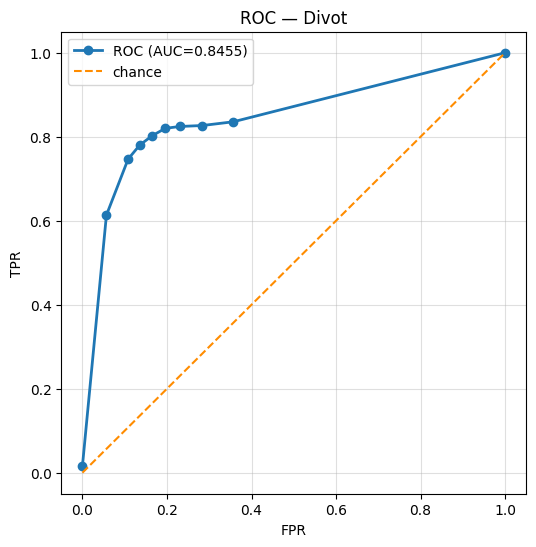

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# === 데이터 (conf=0.001 기준) ===
fpr = [1.0000, 0.3571, 0.2839, 0.2308, 0.1960, 0.1648, 0.1355, 0.1081, 0.0568, 0.0000]
tpr = [1.0000, 0.8356, 0.8267, 0.8244, 0.8200, 0.8022, 0.7800, 0.7467, 0.6133, 0.0156]

# === AUC 계산 ===
roc_auc = auc(fpr[::-1], tpr[::-1])  # 역순 보정
print(f"AUC = {roc_auc:.4f}")

# === 시각화 ===
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, 'o-', label=f'ROC (AUC={roc_auc:.4f})', linewidth=2)
plt.plot([0,1], [0,1], '--', color='darkorange', label='chance')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC — Divot')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from pathlib import Path

# ==============================
# 설정
# ==============================
LABEL_DIR = Path("/home/dw/ws_job_msislab/Golf_Project/data/20250930/20250930_good_data")

# ==============================
# 실행
# ==============================
target_class = "3"
found_files = []

for txt_file in LABEL_DIR.rglob("*.txt"):
    try:
        lines = txt_file.read_text().strip().splitlines()
        for line in lines:
            if line.startswith(f"{target_class} "):
                found_files.append(txt_file)
                break
    except Exception as e:
        print(f"⚠️ Error reading {txt_file}: {e}")

# ==============================
# 결과 출력
# ==============================
print(f"\n총 {len(found_files)}개의 파일에서 class {target_class} (Confused_Object)를 찾았습니다.\n")

for f in sorted(found_files):
    print(f)

# 결과를 텍스트 파일로 저장하고 싶다면 아래 주석 해제
# with open("confused_object_files.txt", "w") as f:
#     f.write("\n".join(str(x) for x in found_files))
# print("\n결과를 confused_object_files.txt 로 저장했습니다.")



총 0개의 파일에서 class 3 (Confused_Object)를 찾았습니다.



In [1]:
from pathlib import Path

# ============================
# 설정
# ============================
LABEL_DIR = Path("/home/dw/ws_job_msislab/Golf_Project/data/for_study/add_data_divot_fixed_sprinkler/labels")

# ============================
# 변환 실행
# ============================
txt_files = sorted(LABEL_DIR.glob("*.txt"))
print(f"총 {len(txt_files)}개의 파일을 확인 중...")

for txt_path in txt_files:
    with open(txt_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    new_lines = []
    modified = False
    for line in lines:
        parts = line.strip().split()
        if not parts:
            continue
        # 첫 번째 값이 클래스 ID
        if parts[0] == "2":
            parts[0] = "5"
            modified = True
        new_lines.append(" ".join(parts) + "\n")

    if modified:
        with open(txt_path, "w", encoding="utf-8") as f:
            f.writelines(new_lines)
        print(f"✅ 수정됨: {txt_path.name}")

print("변환 완료 ✅ (클래스 2 → 5)")


총 262개의 파일을 확인 중...
✅ 수정됨: 20250721_add_10.txt
✅ 수정됨: 20250721_add_20 (copy).txt
✅ 수정됨: 20250721_add_20.txt
✅ 수정됨: 20250721_add_23 (copy).txt
✅ 수정됨: 20250721_add_25 (copy).txt
✅ 수정됨: 20250721_add_27 (copy).txt
✅ 수정됨: 20250721_add_29 (copy).txt
✅ 수정됨: 20250721_add_9.txt
✅ 수정됨: 20250725_add_11.txt
✅ 수정됨: 20250725_add_14.txt
✅ 수정됨: 20250725_add_15.txt
✅ 수정됨: 20250725_add_27.txt
✅ 수정됨: 20250725_add_28 (copy).txt
✅ 수정됨: 20250725_add_28.txt
✅ 수정됨: 20250725_add_29.txt
✅ 수정됨: 20250725_add_30 (copy).txt
✅ 수정됨: 20250725_add_31 (copy).txt
✅ 수정됨: 20250725_add_32 (copy).txt
✅ 수정됨: 20250725_add_32.txt
✅ 수정됨: 20250725_add_4 (copy).txt
✅ 수정됨: 20250725_add_4.txt
✅ 수정됨: 20250725_add_9 (copy).txt
✅ 수정됨: 20250904_add_12.txt
✅ 수정됨: 20250904_add_15.txt
✅ 수정됨: 20250904_add_20.txt
✅ 수정됨: 20250904_add_21 (copy).txt
✅ 수정됨: 20250904_add_23.txt
✅ 수정됨: 20250904_add_24 (copy).txt
✅ 수정됨: 20250904_add_26.txt
✅ 수정됨: 20250904_add_27.txt
✅ 수정됨: 20250904_add_29.txt
✅ 수정됨: 20250904_add_31 (copy).txt
✅ 수정됨: 20250904_add_34